# **Classification**

# **Required File and modules Import**


In [ ]:
import os
import csv
import sqlite3
import dagshub
import mlflow
import joblib
import sklearn
import pandas as pd
import numpy as np
import xgboost as xgb
import mlflow.sklearn
import seaborn as sns
import ydata_profiling
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

# **Required Modules Install**

In [ ]:
#%pip install -q dagshub mlflow
#%pip install ydata-profiling

In [ ]:
file_path = '/content/income_evaluation.csv'

# **CSV Data file Load**


# **Data Cleaning and Normalization**

In [ ]:
# Step 1: Read the data and remove duplicates
rows = []
seen_rows = set()  # This will help us track duplicates

In [ ]:
with open(file_path, mode='r') as file:
    reader = csv.reader(file)
    header = next(reader)  # Read the header row
    rows.append(header)  # Add the header to the rows list

    for row in reader:
        # Remove leading and trailing spaces from each element in the row
        row = [value.strip() for value in row]

        # Convert row to tuple for immutability (to add to set for uniqueness)
        row_tuple = tuple(row)
        if row_tuple not in seen_rows:
            seen_rows.add(row_tuple)
            rows.append(row)



In [ ]:
# Step 2: Handle missing or invalid values
# We will filter out rows where 'workclass' contains ' ?'
# Assuming the 'workclass' column is at index 1 (adjust as needed)

valid_rows = [header]  # Start with the header

for row in rows[1:]:  # Skip the header
    if row[1] != ' ?':  # Check if the 'workclass' column contains ' ?'
        valid_rows.append(row)

# Step 3: Write the cleaned data to a new file
output_file_path = 'cleaned_income_evaluation.csv'
with open(output_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(valid_rows)

print(f"Data cleaned and saved to {output_file_path}")

Data cleaned and saved to cleaned_income_evaluation.csv


# **SQLLIT3 Connection**

In [ ]:
import sqlite3

# Connect to SQLite database (or create it)
conn = sqlite3.connect('income_evaluation.db')
cursor = conn.cursor()


Table schema based on 3NF

In [ ]:

# Create tables based on 3NF design with foreign key relationships
cursor.execute('''
CREATE TABLE IF NOT EXISTS Personal_Details (
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Age INTEGER,
    Race TEXT,
    Sex TEXT,
    Relationship TEXT
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS Employment_Details (
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Personal_ID INTEGER,  -- Foreign key referencing Personal_Details
    Workclass TEXT,
    Occupation TEXT,
    Hours_per_Week INTEGER,
    Income TEXT,
    FOREIGN KEY (Personal_ID) REFERENCES Personal_Details(ID)
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS Education_Details (
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Personal_ID INTEGER,  -- Foreign key referencing Personal_Details
    Education TEXT,
    Education_Num INTEGER,
    FOREIGN KEY (Personal_ID) REFERENCES Personal_Details(ID)
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS Financial_Details (
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Personal_ID INTEGER,  -- Foreign key referencing Personal_Details
    Capital_Gain INTEGER,
    Capital_Loss INTEGER,
    Fnlwgt INTEGER,
    FOREIGN KEY (Personal_ID) REFERENCES Personal_Details(ID)
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS Location_Details (
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Personal_ID INTEGER,  -- Foreign key referencing Personal_Details
    Native_Country TEXT,
    FOREIGN KEY (Personal_ID) REFERENCES Personal_Details(ID)
);
''')

# Commit the changes and close the connection
conn.commit()
conn.close()

print("3NF structure created successfully!")


3NF structure created successfully!


# **Data verification before insertion**

In [ ]:


file_path = 'cleaned_income_evaluation.csv'
with open(file_path, mode='r') as file:
    reader = csv.DictReader(file)  # Using DictReader to read each row as a dictionary
    first_row = next(reader)  # Read the first row to inspect column names

    # Print the column names
    print("Columns in CSV:", first_row.keys())  # Display the keys (column names)

    # Optionally, print the first row's data to verify values
    print("First row data:", first_row)


Columns in CSV: dict_keys(['age', ' workclass', ' fnlwgt', ' education', ' education-num', ' marital-status', ' occupation', ' relationship', ' race', ' sex', ' capital-gain', ' capital-loss', ' hours-per-week', ' native-country', ' income'])
First row data: {'age': '39', ' workclass': 'State-gov', ' fnlwgt': '77516', ' education': 'Bachelors', ' education-num': '13', ' marital-status': 'Never-married', ' occupation': 'Adm-clerical', ' relationship': 'Not-in-family', ' race': 'White', ' sex': 'Male', ' capital-gain': '2174', ' capital-loss': '0', ' hours-per-week': '40', ' native-country': 'United-States', ' income': '<=50K'}


# **Data insertion into new Database**

In [ ]:
# Open the cleaned CSV file and read the data
file_path = 'cleaned_income_evaluation.csv'
with open(file_path, mode='r') as file:
    reader = csv.DictReader(file)  # Using DictReader to read each row as a dictionary

    # Remove leading/trailing spaces from column names
    fieldnames = [field.strip() for field in reader.fieldnames]
    reader.fieldnames = fieldnames  # Update the reader's fieldnames

    data_no_duplicates = [row for row in reader]  # Assuming data_no_duplicates is ready

# Insert data into tables
for row in data_no_duplicates:
    # Insert into Personal_Details table
    cursor.execute('''
    INSERT INTO Personal_Details (Age, Race, Sex, Relationship)
    VALUES (?, ?, ?, ?)
    ''', (row['age'], row['race'], row['sex'], row['relationship']))

    # Get the ID of the last inserted row (Personal_ID)
    personal_id = cursor.lastrowid

    # Insert into Employment_Details table
    cursor.execute('''
    INSERT INTO Employment_Details (Personal_ID, Workclass, Occupation, Hours_per_Week, Income)
    VALUES (?, ?, ?, ?, ?)
    ''', (personal_id, row['workclass'], row['occupation'], row['hours-per-week'], row['income']))

    # Insert into Education_Details table
    cursor.execute('''
    INSERT INTO Education_Details (Personal_ID, Education, Education_Num)
    VALUES (?, ?, ?)
    ''', (personal_id, row['education'], row['education-num']))

    # Insert into Financial_Details table
    cursor.execute('''
    INSERT INTO Financial_Details (Personal_ID, Capital_Gain, Capital_Loss, Fnlwgt)
    VALUES (?, ?, ?, ?)
    ''', (personal_id, row['capital-gain'], row['capital-loss'], row['fnlwgt']))

    # Insert into Location_Details table
    cursor.execute('''
    INSERT INTO Location_Details (Personal_ID, Native_Country)
    VALUES (?, ?)
    ''', (personal_id, row['native-country']))

# Commit the changes and close the connection
conn.commit()
conn.close()

print("Data inserted into 3NF tables successfully!")

# **Data Retrival using SQL**

In [ ]:
import sqlite3
import pandas as pd

# Connect to SQLite database
conn = sqlite3.connect('income_evaluation.db')

# SQL JOIN statement to fetch data from multiple tables
sql_query = '''
SELECT
    pd.Age,
    pd.Race,
    pd.Sex,
    pd.Relationship,
    ed.Workclass,
    ed.Occupation,
    ed.Hours_per_Week,
    ed.Income,
    edu.Education,
    edu.Education_Num,
    fd.Capital_Gain,
    fd.Capital_Loss,
    fd.Fnlwgt,
    ld.Native_Country
FROM
    Personal_Details pd
JOIN
    Employment_Details ed ON pd.ID = ed.Personal_ID
JOIN
    Education_Details edu ON pd.ID = edu.Personal_ID
JOIN
    Financial_Details fd ON pd.ID = fd.Personal_ID
JOIN
    Location_Details ld ON pd.ID = ld.Personal_ID;
'''

# Execute the query and load the data into a Pandas DataFrame
df = pd.read_sql_query(sql_query, conn)

# Close the connection
conn.close()

# Display the first few rows of the DataFrame
print(df.head())


   Age   Race     Sex   Relationship         Workclass         Occupation  \
0   39  White    Male  Not-in-family         State-gov       Adm-clerical   
1   50  White    Male        Husband  Self-emp-not-inc    Exec-managerial   
2   38  White    Male  Not-in-family           Private  Handlers-cleaners   
3   53  Black    Male        Husband           Private  Handlers-cleaners   
4   28  Black  Female           Wife           Private     Prof-specialty   

   Hours_per_Week Income  Education  Education_Num  Capital_Gain  \
0              40  <=50K  Bachelors             13          2174   
1              13  <=50K  Bachelors             13             0   
2              40  <=50K    HS-grad              9             0   
3              40  <=50K       11th              7             0   
4              40  <=50K  Bachelors             13             0   

   Capital_Loss  Fnlwgt Native_Country  
0             0   77516  United-States  
1             0   83311  United-States  
2    

# **Plot Income Distribution**

Income Distribution:
 Income
<=50K    24698
>50K      7839
Name: count, dtype: int64


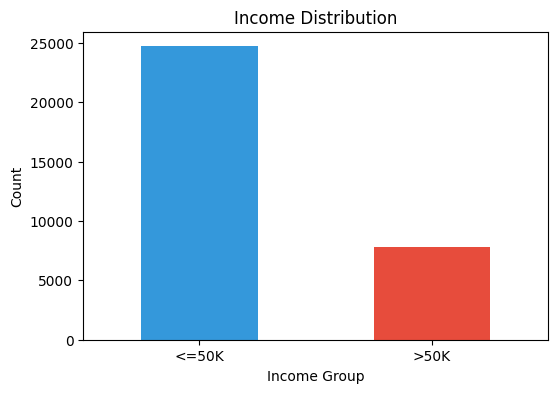

In [ ]:
import pandas as pd

# Assuming 'df' is the Pandas DataFrame containing the joined data
# Check the distribution of the target variable 'Income'
income_distribution = df['Income'].value_counts()

# Display the distribution
print("Income Distribution:\n", income_distribution)

# Visualize the distribution of the 'Income' column
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
income_distribution.plot(kind='bar', color=['#3498db', '#e74c3c'])
plt.title("Income Distribution")
plt.xlabel("Income Group")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


# **Data Spliting in train and test**

In [ ]:
from sklearn.model_selection import train_test_split

# Features (X) and target variable (y)
X = df.drop(columns='Income')  # Features (all columns except 'Income')
y = df['Income']  # Target variable

# Perform stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Check the distribution in the training and test sets
print("Training set Income distribution:\n", y_train.value_counts())
print("Test set Income distribution:\n", y_test.value_counts())


Training set Income distribution:
 Income
<=50K    19758
>50K      6271
Name: count, dtype: int64
Test set Income distribution:
 Income
<=50K    4940
>50K     1568
Name: count, dtype: int64


# **yData Profiling**

In [ ]:
from ydata_profiling import ProfileReport

# Generate the profile report for the DataFrame
profile = ProfileReport(df, title="Income Evaluation Dataset EDA", explorative=True)

# Save the report as an HTML file
profile.to_file("income_evaluation_eda_report.html")

# Optionally, display the report in Jupyter Notebook
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# **Matrix correlation**

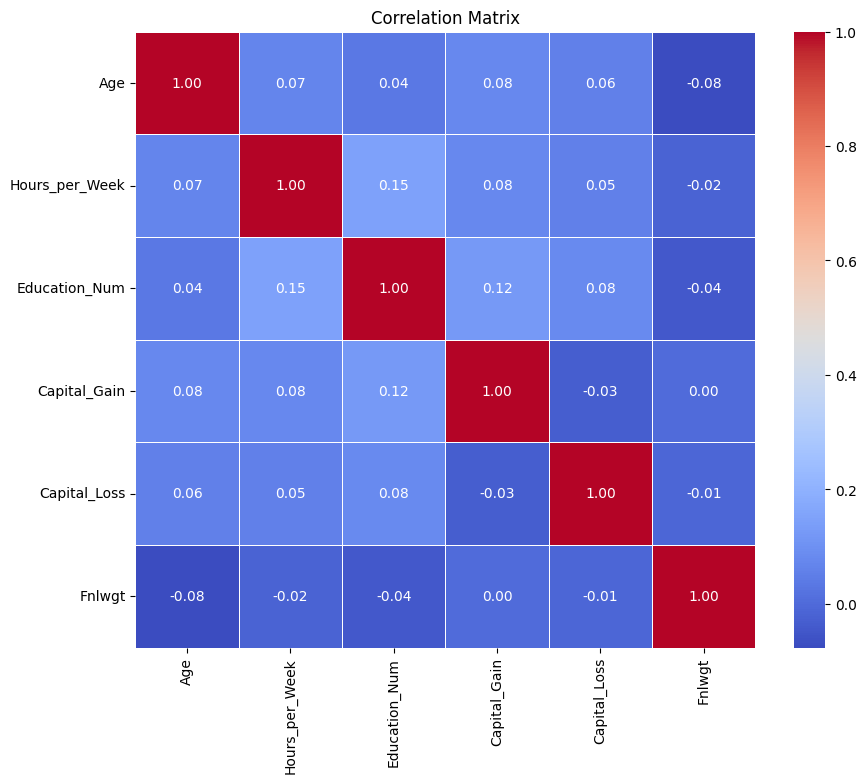

In [ ]:
# Select only numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation matrix for numeric columns
correlation_matrix = df[numeric_columns].corr()

# Plot the correlation matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


# **Dublicate Row check**

In [ ]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


# **Daghub Initialized**

In [ ]:
import dagshub
dagshub.init(repo_owner='Profit188', repo_name='Clasification_Income', mlflow=True)

Initialized MLflow to track repo "Profit188/Clasification_Income"

Repository Profit188/Clasification_Income initialized!

# **MLfLOW intergaration and flow Setup**

In [ ]:
import mlflow
mlflow.set_tracking_uri("https://dagshub.com/Profit188/Clasification_Income.mlflow")

# **Data Verification and ENCODING**

In [ ]:
df

Age   Race     Sex   Relationship         Workclass         Occupation  \
0       39  White    Male  Not-in-family         State-gov       Adm-clerical   
1       50  White    Male        Husband  Self-emp-not-inc    Exec-managerial   
2       38  White    Male  Not-in-family           Private  Handlers-cleaners   
3       53  Black    Male        Husband           Private  Handlers-cleaners   
4       28  Black  Female           Wife           Private     Prof-specialty   
...    ...    ...     ...            ...               ...                ...   
32532   27  White  Female           Wife           Private       Tech-support   
32533   40  White    Male        Husband           Private  Machine-op-inspct   
32534   58  White  Female      Unmarried           Private       Adm-clerical   
32535   22  White    Male      Own-child           Private       Adm-clerical   
32536   52  White  Female           Wife      Self-emp-inc    Exec-managerial   

       Hours_per_Week Income   Education  Education_Num  Capital_Gain  \
0                  40  <=50K   Bachelors             13          2174   
1                  13  <=50K   Bachelors             13             0   
2                  40  <=50K     HS-grad              9             0   
3                  40  <=50K        11th              7             0   
4                  40  <=50K   Bachelors             13             0   
...               ...    ...         ...            ...           ...   
32532              38  <=50K  Assoc-acdm             12             0   
32533              40   >50K     HS-grad              9             0   
32534              40  <=50K     HS-grad              9             0   
32535              20  <=50K     HS-grad              9             0   
32536              40   >50K     HS-grad              9         15024   

       Capital_Loss  Fnlwgt Native_Country  
0                 0   77516  United-States  
1                 0   83311  United-States  
2                 0  215646  United-States  
3                 0  234721  United-States  
4                 0  338409           Cuba  
...             ...     ...            ...  
32532             0  257302  United-States  
32533             0  154374  United-States  
32534             0  151910  United-States  
32535             0  201490  United-States  
32536             0  287927  United-States  

[32537 rows x 14 columns]

In [ ]:
df.drop(columns=['Race'],axis=True)

Age     Sex   Relationship         Workclass         Occupation  \
0       39    Male  Not-in-family         State-gov       Adm-clerical   
1       50    Male        Husband  Self-emp-not-inc    Exec-managerial   
2       38    Male  Not-in-family           Private  Handlers-cleaners   
3       53    Male        Husband           Private  Handlers-cleaners   
4       28  Female           Wife           Private     Prof-specialty   
...    ...     ...            ...               ...                ...   
32532   27  Female           Wife           Private       Tech-support   
32533   40    Male        Husband           Private  Machine-op-inspct   
32534   58  Female      Unmarried           Private       Adm-clerical   
32535   22    Male      Own-child           Private       Adm-clerical   
32536   52  Female           Wife      Self-emp-inc    Exec-managerial   

       Hours_per_Week Income   Education  Education_Num  Capital_Gain  \
0                  40  <=50K   Bachelors             13          2174   
1                  13  <=50K   Bachelors             13             0   
2                  40  <=50K     HS-grad              9             0   
3                  40  <=50K        11th              7             0   
4                  40  <=50K   Bachelors             13             0   
...               ...    ...         ...            ...           ...   
32532              38  <=50K  Assoc-acdm             12             0   
32533              40   >50K     HS-grad              9             0   
32534              40  <=50K     HS-grad              9             0   
32535              20  <=50K     HS-grad              9             0   
32536              40   >50K     HS-grad              9         15024   

       Capital_Loss  Fnlwgt Native_Country  
0                 0   77516  United-States  
1                 0   83311  United-States  
2                 0  215646  United-States  
3                 0  234721  United-States  
4                 0  338409           Cuba  
...             ...     ...            ...  
32532             0  257302  United-States  
32533             0  154374  United-States  
32534             0  151910  United-States  
32535             0  201490  United-States  
32536             0  287927  United-States  

[32537 rows x 13 columns]

In [ ]:
categorical_cols = ["Sex", "Relationship", "Workclass", "Occupation", "Native_Country", "Education"]

# Apply Label Encoding to ordinal columns (e.g., Education)
label_encoder = LabelEncoder()
df["Education"] = label_encoder.fit_transform(df["Education"])

# Apply One-Hot Encoding to nominal columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Now df_encoded has all the categorical variables converted to numerical ones

# Display the first few rows to verify the encoding
print(df_encoded.head())

   Age   Race  Hours_per_Week Income  Education_Num  Capital_Gain  \
0   39  White              40  <=50K             13          2174   
1   50  White              13  <=50K             13             0   
2   38  White              40  <=50K              9             0   
3   53  Black              40  <=50K              7             0   
4   28  Black              40  <=50K             13             0   

   Capital_Loss  Fnlwgt  Sex_Male  Relationship_Not-in-family  ...  \
0             0   77516      True                        True  ...   
1             0   83311      True                       False  ...   
2             0  215646      True                        True  ...   
3             0  234721      True                       False  ...   
4             0  338409     False                       False  ...   

   Education_6  Education_7  Education_8  Education_9  Education_10  \
0        False        False        False         True         False   
1        False        

In [ ]:
df_encoded = df_encoded.drop('Race', axis=1)

In [ ]:
df_encoded['Income'] = df_encoded['Income'].map({'<=50K': 0, '>50K': 1})

In [ ]:
df_encoded = df_encoded.astype(int)

# **Encoding Verification**

In [ ]:
df_encoded

Age  Hours_per_Week  Income  Education_Num  Capital_Gain  Capital_Loss  \
0       39              40       0             13          2174             0   
1       50              13       0             13             0             0   
2       38              40       0              9             0             0   
3       53              40       0              7             0             0   
4       28              40       0             13             0             0   
...    ...             ...     ...            ...           ...           ...   
32532   27              38       0             12             0             0   
32533   40              40       1              9             0             0   
32534   58              40       0              9             0             0   
32535   22              20       0              9             0             0   
32536   52              40       1              9         15024             0   

       Fnlwgt  Sex_Male  Relationship_Not-in-family  \
0       77516         1                           1   
1       83311         1                           0   
2      215646         1                           1   
3      234721         1                           0   
4      338409         0                           0   
...       ...       ...                         ...   
32532  257302         0                           0   
32533  154374         1                           0   
32534  151910         0                           0   
32535  201490         1                           0   
32536  287927         0                           0   

       Relationship_Other-relative  ...  Education_6  Education_7  \
0                                0  ...            0            0   
1                                0  ...            0            0   
2                                0  ...            0            0   
3                                0  ...            0            0   
4                                0  ...            0            0   
...                            ...  ...          ...          ...   
32532                            0  ...            0            1   
32533                            0  ...            0            0   
32534                            0  ...            0            0   
32535                            0  ...            0            0   
32536                            0  ...            0            0   

       Education_8  Education_9  Education_10  Education_11  Education_12  \
0                0            1             0             0             0   
1                0            1             0             0             0   
2                0            0             0             1             0   
3                0            0             0             0             0   
4                0            1             0             0             0   
...            ...          ...           ...           ...           ...   
32532            0            0             0             0             0   
32533            0            0             0             1             0   
32534            0            0             0             1             0   
32535            0            0             0             1             0   
32536            0            0             0             1             0   

       Education_13  Education_14  Education_15  
0                 0             0             0  
1                 0             0             0  
2                 0             0             0  
3                 0             0             0  
4                 0             0             0  
...             ...           ...           ...  
32532             0             0             0  
32533             0             0             0  
32534             0             0             0  
32535             0             0             0  
32536             0             0             0  

[32537 rows x 91 c

# **EXEPRIMENT 1**

In [ ]:

# Split data into features and target
X = df_encoded.drop(columns=['Income'])
y = df_encoded['Income']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['number']).columns

# Define the preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define the pipeline with Logistic Regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Cross-validation setup
cv = 10  # Number of folds for cross-validation



In [ ]:
mlflow.set_experiment("Experiment 1 - Income_Classification_Experiment")


<Experiment: artifact_location='mlflow-artifacts:/263ae57d632843998ead634b1c83dd36', creation_time=1734498077130, experiment_id='10', last_update_time=1734498077130, lifecycle_stage='active', name='Experiment 1 - Income_Classification_Experiment', tags={}>

In [ ]:
# Start MLflow run
with mlflow.start_run(run_name="Experiment 1"):
    # Train the model and perform cross-validation
    scores = cross_validate(
        pipeline, X_train, y_train, cv=cv, scoring='f1', return_train_score=True
    )

    # Get the mean and standard deviation of F1-scores
    mean_f1 = np.mean(scores['test_score'])
    std_f1 = np.std(scores['test_score'])

    # Log metrics with MLflow
    mlflow.log_metric('mean_f1_score', mean_f1)
    mlflow.log_metric('std_f1_score', std_f1)

    # Hyperparameter tuning using GridSearchCV
    param_grid = {
        'classifier__C': [0.1, 1, 10],  # Regularization parameter for Logistic Regression
        'classifier__penalty': ['l2', 'l1'],  # Regularization penalties
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Log the best hyperparameters
    best_params = grid_search.best_params_
    mlflow.log_params(best_params)

    # Evaluate on the test set
    y_pred = grid_search.predict(X_test)
    f1_test = f1_score(y_test, y_pred, average='binary')
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Log the results on the test set
    mlflow.log_metric('f1_test', f1_test)
    mlflow.log_metric('tn', tn)
    mlflow.log_metric('fp', fp)
    mlflow.log_metric('fn', fn)
    mlflow.log_metric('tp', tp)

    # Log the trained model
    mlflow.sklearn.log_model(grid_search.best_estimator_, "logistic_regression_model")

print("Experiment complete and results logged to MLflow!")

2024/12/18 05:12:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Experiment 1 at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/10/runs/3af84efd7cc54c0793027c7acb0933ba
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/10
Experiment complete and results logged to MLflow!


# **DATaFrame Nan Value and encoding check**

In [ ]:
print(f"Number of NaN values in 'income': {df_encoded['Income'].isna().sum()}")


Number of NaN values in 'income': 0


In [ ]:
df_encoded.columns

Index(['Age', 'Hours_per_Week', 'Income', 'Education_Num', 'Capital_Gain',
       'Capital_Loss', 'Fnlwgt', 'Sex_Male', 'Relationship_Not-in-family',
       'Relationship_Other-relative', 'Relationship_Own-child',
       'Relationship_Unmarried', 'Relationship_Wife', 'Workclass_Federal-gov',
       'Workclass_Local-gov', 'Workclass_Never-worked', 'Workclass_Private',
       'Workclass_Self-emp-inc', 'Workclass_Self-emp-not-inc',
       'Workclass_State-gov', 'Workclass_Without-pay',
       'Occupation_Adm-clerical', 'Occupation_Armed-Forces',
       'Occupation_Craft-repair', 'Occupation_Exec-managerial',
       'Occupation_Farming-fishing', 'Occupation_Handlers-cleaners',
       'Occupation_Machine-op-inspct', 'Occupation_Other-service',
       'Occupation_Priv-house-serv', 'Occupation_Prof-specialty',
       'Occupation_Protective-serv', 'Occupation_Sales',
       'Occupation_Tech-support', 'Occupation_Transport-moving',
       'Native_Country_Cambodia', 'Native_Country_Canada',
    

# **EXPERIMENT 2**

In [ ]:


# Assuming df is already loaded and cleaned
# Separate features and target
X = df_encoded.drop("Income", axis=1)  # 'income' is the target column
y = df_encoded["Income"]

# Encode Target Variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Define models for the pipeline
models = {
    "LogisticRegression": LogisticRegression(solver="liblinear"),
    "RidgeClassifier": RidgeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBClassifier": xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
}

# Cross-validation & Metrics Logging
def log_metrics(model, X, y):
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    return {"F1-Score": f1, "TP": tp, "TN": tn, "FP": fp, "FN": fn}

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# MLFlow Experiment
mlflow.set_experiment("Experiment #2")

# Loop through models and log metrics to MLFlow
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("Model", model_name)

        # Create pipeline for each model
        pipeline = Pipeline([
            ("classifier", model)
        ])

        # Cross-Validation
        kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring="f1_macro")
        mean_score = scores.mean()
        std_score = scores.std()

        # Train the model on the full training data
        pipeline.fit(X_train, y_train)
        metrics = log_metrics(pipeline, X_test, y_test)

        # Log Metrics to MLFlow
        mlflow.log_metric("Mean_CV_F1", mean_score)
        mlflow.log_metric("STD_CV_F1", std_score)
        for key, value in metrics.items():
            mlflow.log_metric(key, value)

        # Log the model
        mlflow.sklearn.log_model(pipeline, f"{model_name}_pipeline")

        print(f"Model: {model_name}")
        print(f"Mean CV F1-Score: {mean_score:.4f}, STD: {std_score:.4f}")


2024/12/18 05:18:07 INFO mlflow.tracking.fluent: Experiment with name 'Experiment #2' does not exist. Creating a new experiment.
2024/12/18 05:18:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: LogisticRegression
Mean CV F1-Score: 0.6309, STD: 0.0022
🏃 View run LogisticRegression at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/11/runs/027bac70dc3a4b31a6e08501267f306c
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/11


2024/12/18 05:18:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RidgeClassifier
Mean CV F1-Score: 0.7490, STD: 0.0030
🏃 View run RidgeClassifier at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/11/runs/b15ae13f9ece4dae9b08c81252f3b05e
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/11


2024/12/18 05:18:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RandomForestClassifier
Mean CV F1-Score: 0.7802, STD: 0.0072
🏃 View run RandomForestClassifier at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/11/runs/567d866729cf4c15a3d39d5856c69e95
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/11


2024/12/18 05:19:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: XGBClassifier
Mean CV F1-Score: 0.8087, STD: 0.0037
🏃 View run XGBClassifier at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/11/runs/32879804465e45bdae72af6ee4a793b3
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/11


# **EXPERIMENT 3**

In [ ]:
mlflow.set_experiment("Experiment #3")

2024/12/18 05:19:51 INFO mlflow.tracking.fluent: Experiment with name 'Experiment #3' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1849dc4eba284290ba21e28f764db764', creation_time=1734499191694, experiment_id='12', last_update_time=1734499191694, lifecycle_stage='active', name='Experiment #3', tags={}>

In [ ]:
df_encoded['Age_to_hours_ratio'] = df_encoded['Age'] / df_encoded['Hours_per_Week']
df_encoded['Age_squared'] = df_encoded['Age'] ** 2
df_encoded['Hours_per_week_squared'] = df_encoded['Hours_per_Week'] ** 2

# You can create interaction features like the product of age and hours-per-week
df_encoded['Age_hours_interaction'] = df_encoded['Age'] * df_encoded['Hours_per_Week']

# Separate features and target
X = df_encoded.drop("Income", axis=1)  # 'income' is the target column
y = df_encoded["Income"]

# Encode Target Variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Define models for the pipeline
models = {
    "LogisticRegression": LogisticRegression(solver="liblinear"),
    "RidgeClassifier": RidgeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBClassifier": xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
}

# Cross-validation & Metrics Logging
def log_metrics(model, X, y):
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    return {"F1-Score": f1, "TP": tp, "TN": tn, "FP": fp, "FN": fn}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Loop through models and log metrics to MLFlow
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("Model", model_name)

        # Create pipeline for each model
        pipeline = Pipeline([
            ("classifier", model)
        ])

        # Cross-Validation
        kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring="f1_macro")
        mean_score = scores.mean()
        std_score = scores.std()

        # Train the model on the full training data
        pipeline.fit(X_train, y_train)
        metrics = log_metrics(pipeline, X_test, y_test)

        # Log Metrics to MLFlow
        mlflow.log_metric("Mean_CV_F1", mean_score)
        mlflow.log_metric("STD_CV_F1", std_score)
        for key, value in metrics.items():
            mlflow.log_metric(key, value)

        # Log the model
        mlflow.sklearn.log_model(pipeline, f"{model_name}_pipeline")

        print(f"Model: {model_name}")
        print(f"Mean CV F1-Score: {mean_score:.4f}, STD: {std_score:.4f}")

2024/12/18 05:21:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: LogisticRegression
Mean CV F1-Score: 0.6577, STD: 0.0105
🏃 View run LogisticRegression at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/12/runs/da8d7326a37243a88f5ae01a99a36cb8
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/12


2024/12/18 05:22:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RidgeClassifier
Mean CV F1-Score: 0.7538, STD: 0.0031
🏃 View run RidgeClassifier at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/12/runs/c33c30a97ddb45a3868b635f97cb72e6
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/12


2024/12/18 05:22:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RandomForestClassifier
Mean CV F1-Score: 0.7767, STD: 0.0088
🏃 View run RandomForestClassifier at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/12/runs/56bdbb043c274bc498677c79ba145563
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/12


2024/12/18 05:22:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: XGBClassifier
Mean CV F1-Score: 0.8072, STD: 0.0026
🏃 View run XGBClassifier at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/12/runs/111f2c64e80440baa981042ae0a06ce7
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/12


# **EXPERIMENT 4**

In [ ]:
mlflow.set_experiment("Experiment #4")

2024/12/18 05:23:10 INFO mlflow.tracking.fluent: Experiment with name 'Experiment #4' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/4264271b807248988f86c26f4b896100', creation_time=1734499390083, experiment_id='13', last_update_time=1734499390083, lifecycle_stage='active', name='Experiment #4', tags={}>

In [ ]:
from sklearn.feature_selection import VarianceThreshold
X = df_encoded.drop("Income", axis=1)  # 'income' is the target column
y = df_encoded["Income"]
def correlation_threshold(X, threshold=0.9):
    corr_matrix = X.corr()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > threshold)]
    return X.drop(columns=to_drop)

# Feature Selection Method 2: Feature Importance using RandomForestClassifier
def feature_importance(X, y):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
    important_features = feature_importance[feature_importance > 0.01]  # Set a threshold for importance
    return X[important_features.index]

# Feature Selection Method 3: Variance Threshold
def variance_threshold(X, threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    return X.loc[:, selector.fit(X).get_support()]

In [ ]:
df_encoded.columns

Index(['Age', 'Hours_per_Week', 'Income', 'Education_Num', 'Capital_Gain',
       'Capital_Loss', 'Fnlwgt', 'Sex_Male', 'Relationship_Not-in-family',
       'Relationship_Other-relative', 'Relationship_Own-child',
       'Relationship_Unmarried', 'Relationship_Wife', 'Workclass_Federal-gov',
       'Workclass_Local-gov', 'Workclass_Never-worked', 'Workclass_Private',
       'Workclass_Self-emp-inc', 'Workclass_Self-emp-not-inc',
       'Workclass_State-gov', 'Workclass_Without-pay',
       'Occupation_Adm-clerical', 'Occupation_Armed-Forces',
       'Occupation_Craft-repair', 'Occupation_Exec-managerial',
       'Occupation_Farming-fishing', 'Occupation_Handlers-cleaners',
       'Occupation_Machine-op-inspct', 'Occupation_Other-service',
       'Occupation_Priv-house-serv', 'Occupation_Prof-specialty',
       'Occupation_Protective-serv', 'Occupation_Sales',
       'Occupation_Tech-support', 'Occupation_Transport-moving',
       'Native_Country_Cambodia', 'Native_Country_Canada',
    

In [ ]:
X = df_encoded.drop("Income", axis=1)  # 'income' is the target column
y = df_encoded["Income"]

df_encoded['Age_squared'] = df_encoded['Age'] ** 2
df_encoded['Age_to_hours_ratio'] = df_encoded['Age'] / df_encoded['Hours_per_Week']
df_encoded['Hours_per_week_squared'] = df_encoded['Hours_per_Week'] ** 2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

for feature_selection_method, selector in {
    "Correlation_Threshold": correlation_threshold,
    "Feature_Importance": feature_importance,
    "Variance_Threshold": variance_threshold,
}.items():
    with mlflow.start_run(run_name=f"Experiment 4 - {feature_selection_method}"):
        mlflow.log_param("Feature Selection Method", feature_selection_method)

        # Apply the feature selection method
        if feature_selection_method == "Correlation_Threshold":
            X_train_selected = selector(X_train, threshold=0.9)
            X_test_selected = selector(X_test, threshold=0.9)
        elif feature_selection_method == "Feature_Importance":
            X_train_selected = selector(X_train, y_train)
            X_test_selected = selector(X_test, y_test)
        elif feature_selection_method == "Variance_Threshold":
            X_train_selected = selector(X_train, threshold=0.01)
            X_test_selected = selector(X_test, threshold=0.01)

        # Ensure both training and testing datasets have the same columns
        common_columns = X_train_selected.columns.intersection(X_test_selected.columns)
        X_train_selected = X_train_selected[common_columns]
        X_test_selected = X_test_selected[common_columns]

        # Log the selected features
        mlflow.log_param("Selected Features", X_train_selected.columns.tolist())

        # Define models for the pipeline
        models = {
            "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
            "XGBClassifier": xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
        }

        for model_name, model in models.items():
            # Use a nested run to avoid parameter overwriting
            with mlflow.start_run(nested=True):
                mlflow.log_param("Model", model_name)

                # Create pipeline for each model
                pipeline = Pipeline([
                    ("classifier", model)
                ])

                # Cross-Validation
                kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
                scores = cross_val_score(pipeline, X_train_selected, y_train, cv=kfold, scoring="f1_macro")
                mean_score = scores.mean()
                std_score = scores.std()

                # Train the model on the full training data
                pipeline.fit(X_train_selected, y_train)
                y_pred = pipeline.predict(X_test_selected)
                f1 = f1_score(y_test, y_pred)
                tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

                # Log metrics to MLFlow
                mlflow.log_metric("Mean_CV_F1", mean_score)
                mlflow.log_metric("STD_CV_F1", std_score)
                mlflow.log_metric("F1-Score", f1)
                mlflow.log_metric("TP", tp)
                mlflow.log_metric("TN", tn)
                mlflow.log_metric("FP", fp)
                mlflow.log_metric("FN", fn)

                # Log the model
                mlflow.sklearn.log_model(pipeline, f"{model_name}_pipeline")

                print(f"Feature Selection Method: {feature_selection_method}, Model: {model_name}")
                print(f"Mean CV F1-Score: {mean_score:.4f}, STD: {std_score:.4f}")




2024/12/18 05:23:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Feature Selection Method: Correlation_Threshold, Model: RandomForestClassifier
Mean CV F1-Score: 0.7788, STD: 0.0083
🏃 View run nimble-donkey-971 at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/13/runs/3c44d977ac19491891d7bb384029c35e
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/13


2024/12/18 05:23:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Feature Selection Method: Correlation_Threshold, Model: XGBClassifier
Mean CV F1-Score: 0.8072, STD: 0.0026
🏃 View run delicate-smelt-532 at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/13/runs/06dff37e5a1149b4b6d69c1fb058bc8d
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/13
🏃 View run Experiment 4 - Correlation_Threshold at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/13/runs/a192017464ad484195e95d6b6277147e
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/13


2024/12/18 05:24:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Feature Selection Method: Feature_Importance, Model: RandomForestClassifier
Mean CV F1-Score: 0.7683, STD: 0.0075
🏃 View run rogue-doe-380 at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/13/runs/929e492a28ae4f8e8e007505cd76334f
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/13


2024/12/18 05:24:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Feature Selection Method: Feature_Importance, Model: XGBClassifier
Mean CV F1-Score: 0.7910, STD: 0.0027
🏃 View run awesome-stag-198 at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/13/runs/1ff1622bb00844f5a6179d62751e5e49
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/13
🏃 View run Experiment 4 - Feature_Importance at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/13/runs/b7ac55c61585438e98cc808b7150d07e
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/13


2024/12/18 05:25:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Feature Selection Method: Variance_Threshold, Model: RandomForestClassifier
Mean CV F1-Score: 0.7771, STD: 0.0077
🏃 View run sneaky-bear-855 at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/13/runs/b1a79a7724794aa9bfb01ea173b94051
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/13


2024/12/18 05:25:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Feature Selection Method: Variance_Threshold, Model: XGBClassifier
Mean CV F1-Score: 0.8058, STD: 0.0048
🏃 View run delightful-boar-700 at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/13/runs/725ce1b09af646258b8a8bae6cc7f572
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/13
🏃 View run Experiment 4 - Variance_Threshold at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/13/runs/279cdc040c8b40cb91e855d8874d26fa
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/13


# **EXPERIMENT 5**

In [ ]:
mlflow.set_experiment("Experiment #5")

2024/12/18 05:26:07 INFO mlflow.tracking.fluent: Experiment with name 'Experiment #5' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/42484f47c09543a0891ae762a3e256d0', creation_time=1734499567278, experiment_id='14', last_update_time=1734499567278, lifecycle_stage='active', name='Experiment #5', tags={}>

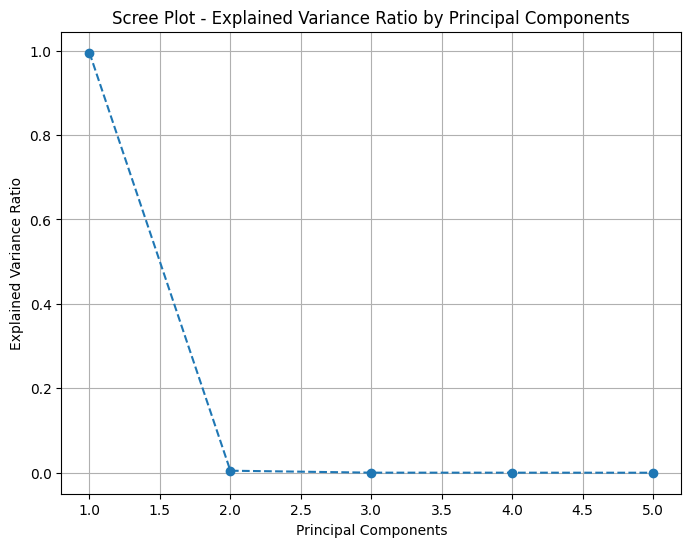

2024/12/18 05:26:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RandomForestClassifier
Mean CV F1-Score: 0.6784, STD: 0.0062
🏃 View run likeable-gull-921 at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/14/runs/b800f98e652d445a9f8deb7f9da6239d
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/14
🏃 View run Experiment 5 - PCA with 5 components at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/14/runs/5431f607f5b64c59a6026d954b3d1985
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/14


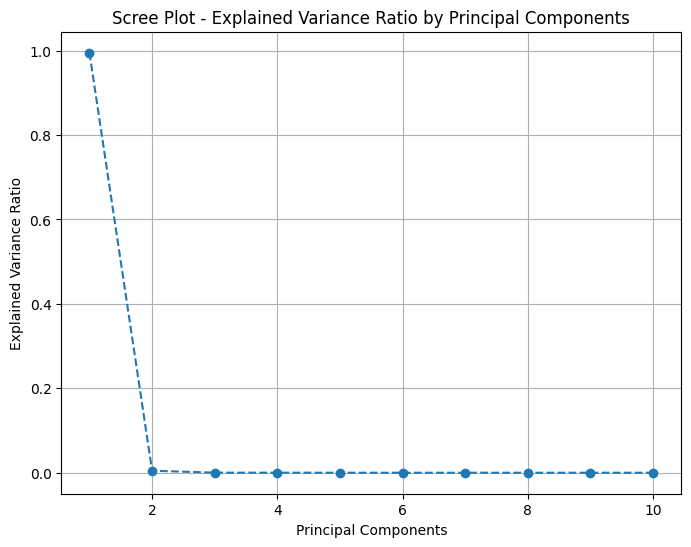

2024/12/18 05:27:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RandomForestClassifier
Mean CV F1-Score: 0.7144, STD: 0.0054
🏃 View run welcoming-snail-139 at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/14/runs/738d9286cf4646d7adcf84c31dcbb234
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/14
🏃 View run Experiment 5 - PCA with 10 components at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/14/runs/3fad09d07f044f4e8cad4950555dc1cb
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/14


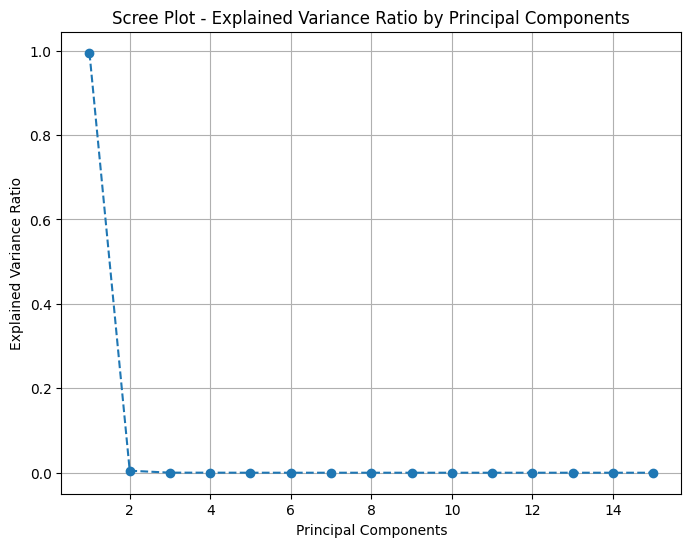

2024/12/18 05:28:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RandomForestClassifier
Mean CV F1-Score: 0.7662, STD: 0.0076
🏃 View run bedecked-swan-462 at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/14/runs/79e3f899ca99441b8ee16cb70041c726
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/14
🏃 View run Experiment 5 - PCA with 15 components at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/14/runs/78403c0307d2454892c55d66ba6eefb0
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/14


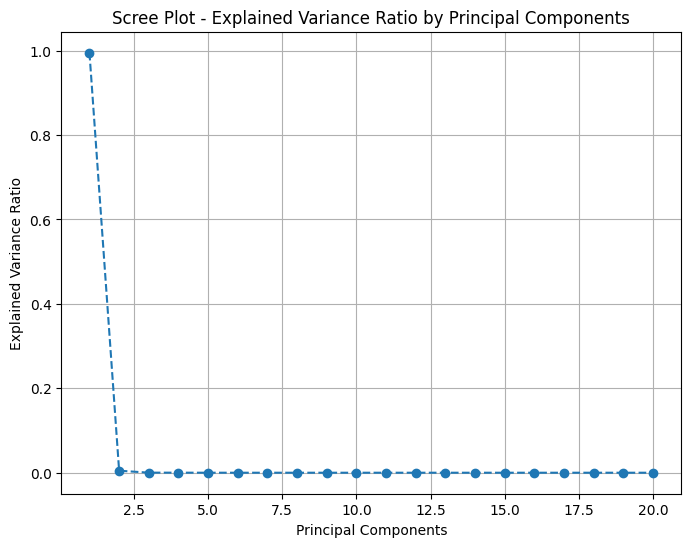

2024/12/18 05:30:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: RandomForestClassifier
Mean CV F1-Score: 0.7709, STD: 0.0072
🏃 View run rumbling-gnu-632 at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/14/runs/47953eecb11d42498c88f8573042e65a
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/14
🏃 View run Experiment 5 - PCA with 20 components at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/14/runs/ece5867250bb477cbed81c06155c935d
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/14


In [ ]:


# Apply PCA for dimensionality reduction
def pca_experiment(X_train, X_test, y_train, y_test, n_components=None):
    # Initialize PCA
    pca = PCA(n_components=n_components)

    # Fit PCA on training data
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Create a scree plot (explained variance ratio)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
    plt.title("Scree Plot - Explained Variance Ratio by Principal Components")
    plt.xlabel("Principal Components")
    plt.ylabel("Explained Variance Ratio")
    plt.grid(True)
    plt.show()

    # Log PCA components and explained variance to MLFlow
    mlflow.log_param("PCA_n_components", n_components)
    mlflow.log_param("Explained_Variance_Ratio", pca.explained_variance_ratio_.tolist())

    # Now, we can apply classification models on the reduced features (X_train_pca and X_test_pca)
    models = {
        "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    }

    for model_name, model in models.items():
        # Nested run to avoid parameter overwriting
        with mlflow.start_run(nested=True):
            mlflow.log_param("Model", model_name)

            # Define a pipeline for the model
            pipeline = Pipeline([
                ("classifier", model)
            ])

            # Cross-Validation
            kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            scores = cross_val_score(pipeline, X_train_pca, y_train, cv=kfold, scoring="f1_macro")
            mean_score = scores.mean()
            std_score = scores.std()

            # Train the model on the full training data
            pipeline.fit(X_train_pca, y_train)
            y_pred = pipeline.predict(X_test_pca)
            f1 = f1_score(y_test, y_pred)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

            # Log metrics to MLFlow
            mlflow.log_metric("Mean_CV_F1", mean_score)
            mlflow.log_metric("STD_CV_F1", std_score)
            mlflow.log_metric("F1-Score", f1)
            mlflow.log_metric("TP", tp)
            mlflow.log_metric("TN", tn)
            mlflow.log_metric("FP", fp)
            mlflow.log_metric("FN", fn)

            # Log the model to MLFlow
            mlflow.sklearn.log_model(pipeline, f"{model_name}_pipeline")

            print(f"Model: {model_name}")
            print(f"Mean CV F1-Score: {mean_score:.4f}, STD: {std_score:.4f}")

# Run the PCA experiment
for n_components in [5, 10, 15, 20]:  # Test with different numbers of components
    with mlflow.start_run(run_name=f"Experiment 5 - PCA with {n_components} components"):
        pca_experiment(X_train, X_test, y_train, y_test, n_components)


# **EXPERIMENT 6**

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline

In [ ]:
mlflow.set_experiment("Experiment #6")


2024/12/18 05:30:29 INFO mlflow.tracking.fluent: Experiment with name 'Experiment #6' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/61e15b66b9054dce99ed31356187c997', creation_time=1734499829594, experiment_id='15', last_update_time=1734499829594, lifecycle_stage='active', name='Experiment #6', tags={}>

In [ ]:


X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Initialize SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Create a pipeline that applies SMOTE and then fits a RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
pipeline = imPipeline(steps=[('smote', smote), ('classifier', model)])

In [ ]:
with mlflow.start_run(run_name="SMOTE Analysis Experiment"):

    # Fit the model on the resampled training data
    pipeline.fit(X_train, y_train)

    # Predict on the test data
    y_pred = pipeline.predict(X_test)

    # Calculate metrics
    f1 = f1_score(y_test, y_pred, average='macro')
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    report = classification_report(y_test, y_pred, output_dict=True)

    # Log the metrics and confusion matrix to MLFlow
    mlflow.log_metric("F1_Score", f1)
    mlflow.log_metric("TP", tp)
    mlflow.log_metric("TN", tn)
    mlflow.log_metric("FP", fp)
    mlflow.log_metric("FN", fn)

    # Log the classification report as a JSON string
    mlflow.log_param("Classification_Report", str(report))

    # Log the trained model
    mlflow.sklearn.log_model(pipeline, "smote_random_forest_model")

    # Output evaluation results
    print(f"F1-Score: {f1:.4f}")
    print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")
    print(f"Classification Report: \n{classification_report(y_test, y_pred)}")

2024/12/18 05:31:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


F1-Score: 0.7808
Confusion Matrix: 
[[3582  370]
 [ 447  807]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      3952
           1       0.69      0.64      0.66      1254

    accuracy                           0.84      5206
   macro avg       0.79      0.77      0.78      5206
weighted avg       0.84      0.84      0.84      5206

🏃 View run SMOTE Analysis Experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/15/runs/599ce6a412964245a1d7cc7374d096f0
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/15


# **EXPERIMENT 7**

In [ ]:
mlflow.set_experiment("Experiment #7")

2024/12/18 05:31:25 INFO mlflow.tracking.fluent: Experiment with name 'Experiment #7' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/eeb9781dc995498cbeeab1edc38b25d1', creation_time=1734499885101, experiment_id='16', last_update_time=1734499885101, lifecycle_stage='active', name='Experiment #7', tags={}>

Explained Variance by PCA (top 5 components): [0.0421921  0.02894345 0.02618861 0.02226558 0.01839992]
t-SNE visualization saved at: tsne_plot.png
🏃 View run t-SNE Dimensionality Reduction Experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/16/runs/7a68d4c7a6a441d7a2f9c578b1e4a6ab
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/16


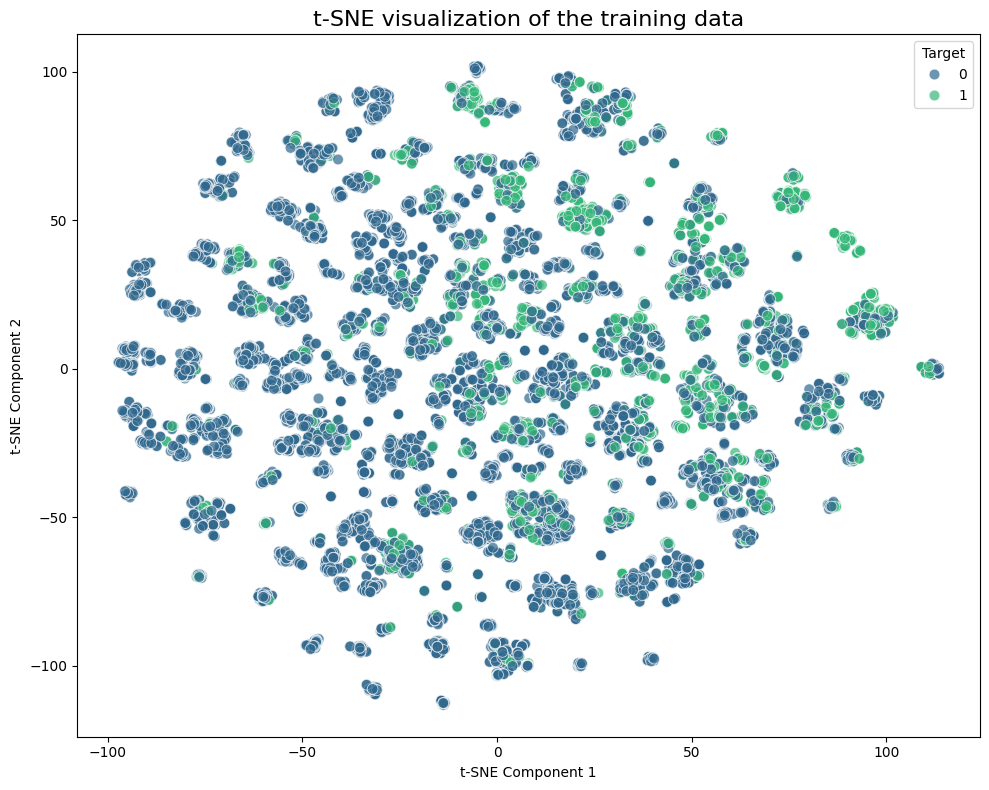

In [ ]:


# Assuming X_train and y_train are your features and labels
# X_train = <Your Feature Data>
# y_train = <Your Target Labels>

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Standardizing the features (important for t-SNE)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Initialize and fit t-SNE with the scaled features
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_scaled)

# Visualize the t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_train, palette="viridis", s=60, alpha=0.7)
plt.title("t-SNE visualization of the training data", fontsize=16)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Target", loc="best")
plt.tight_layout()

# Log the t-SNE visualization in MLFlow
with mlflow.start_run(run_name="t-SNE Dimensionality Reduction Experiment"):
    # Log the t-SNE plot as an artifact in MLFlow
    plot_path = "tsne_plot.png"
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)

    # Log the explained variance (before applying t-SNE, PCA could be used for dimensionality reduction if needed)
    pca = PCA(n_components=5)
    X_pca = pca.fit_transform(X_train_scaled)
    explained_variance = pca.explained_variance_ratio_

    # Log PCA explained variance ratio
    mlflow.log_metric("PCA_Explained_Variance_Ratio", explained_variance.sum())

    # Optionally log the PCA components and t-SNE components for reference
    mlflow.log_param("PCA_Components", str(pca.components_))
    mlflow.log_param("t-SNE_Components", str(X_tsne[:5]))  # Log the first 5 rows of t-SNE components

    # Output evaluation results
    print(f"Explained Variance by PCA (top 5 components): {explained_variance}")
    print(f"t-SNE visualization saved at: {plot_path}")


# **EXPERIMENT 8  -F1-score plots**

In [ ]:
mlflow.set_experiment("Experiment #8")

2024/12/18 06:16:23 INFO mlflow.tracking.fluent: Experiment with name 'Experiment #8' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/8a15fd545f3c426abadc4fcbc0bfbde3', creation_time=1734502583244, experiment_id='17', last_update_time=1734502583244, lifecycle_stage='active', name='Experiment #8', tags={}>

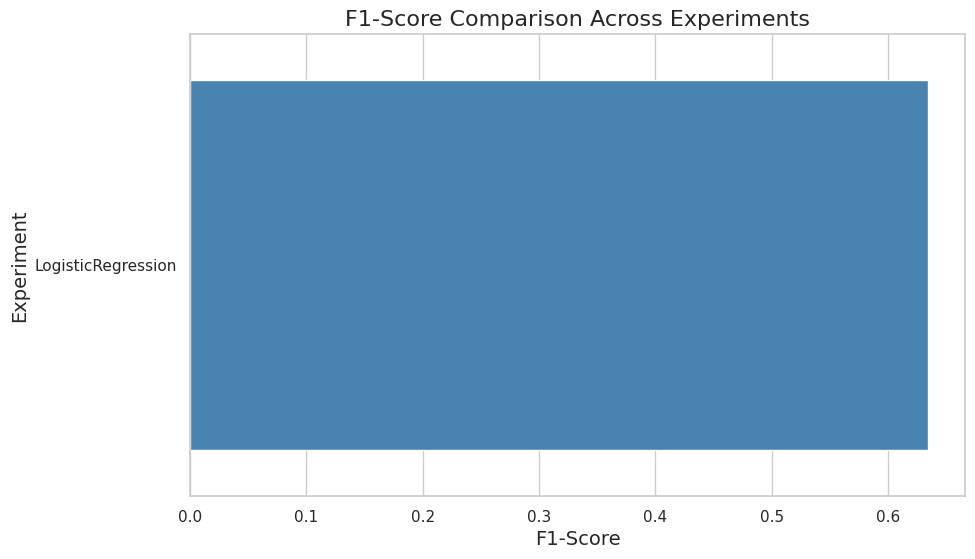

🏃 View run LogisticRegression at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/17/runs/1bf7629d67ef49fda451b2dfb1cc3200
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/17


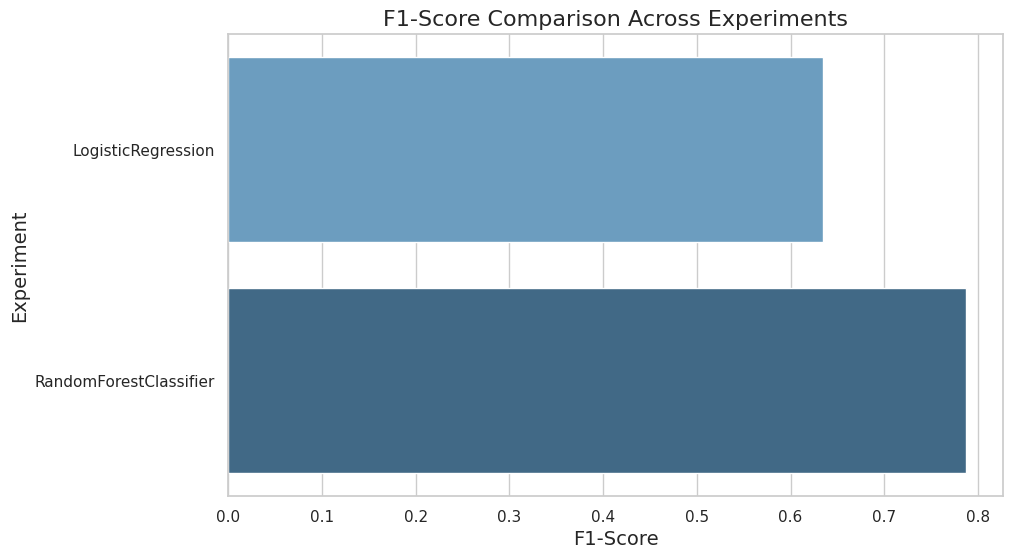

🏃 View run RandomForestClassifier at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/17/runs/35f4bfcc57e64b479e24b079c635c919
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/17


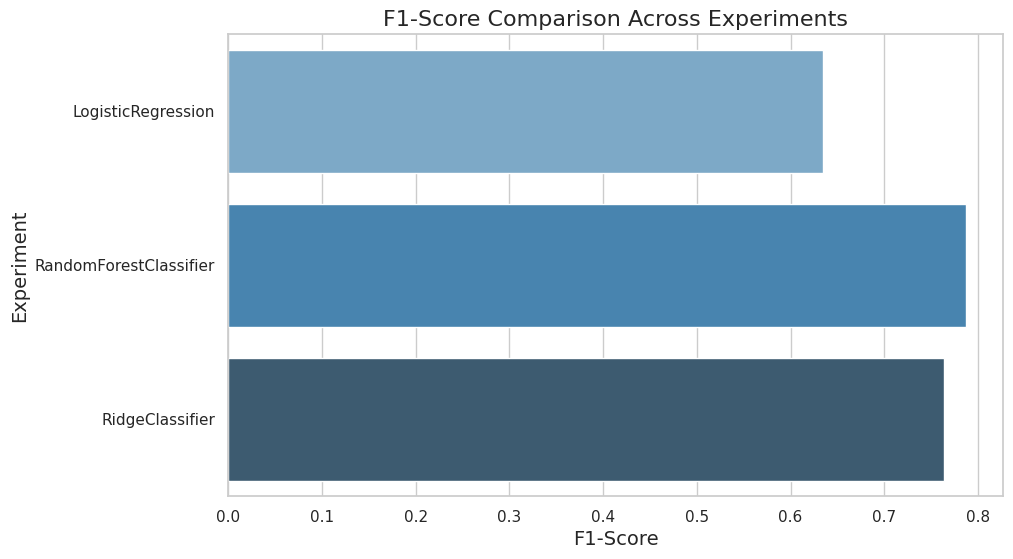

🏃 View run RidgeClassifier at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/17/runs/3e533cb7c561427c9e23cae91810872c
🧪 View experiment at: https://dagshub.com/Profit188/Clasification_Income.mlflow/#/experiments/17


In [ ]:
import os
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define a function to run the models and log the results
def run_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = model.predict(X_test)

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred, average='macro')

    # Return the F1 score for logging and plotting
    return f1

# List of models (instantiating the models here)
models = [
    ('LogisticRegression', LogisticRegression()),  # Instantiate the model
    ('RandomForestClassifier', RandomForestClassifier()),  # Instantiate the model
    ('RidgeClassifier', RidgeClassifier())   # Instantiate the model
]

experiment_results = []

# Start an MLFlow run for each experiment
for experiment_name, model in models:
    with mlflow.start_run(run_name=experiment_name):
        # Run the model and get the F1 score
        f1 = run_model(model, X_train, y_train, X_test, y_test)

        # Log the F1 score to MLFlow
        mlflow.log_metric("F1_Score", f1)

        # Store the result for plotting
        experiment_results.append({'Experiment': experiment_name, 'F1_Score': f1})

        # Create a DataFrame with the results for plotting after the run
        df_1 = pd.DataFrame(experiment_results)

        # Set the style of the plot using seaborn
        sns.set(style="whitegrid")

        # Create a bar plot for F1-scores
        plt.figure(figsize=(10, 6))
        sns.barplot(x='F1_Score', y='Experiment', data=df_1, palette='Blues_d')

        # Add labels and title
        plt.title('F1-Score Comparison Across Experiments', fontsize=16)
        plt.xlabel('F1-Score', fontsize=14)
        plt.ylabel('Experiment', fontsize=14)

        # Save the plot to a file
        plot_filename = 'f1_score_comparison.png'
        plt.savefig(plot_filename)

        # Log the plot as an artifact in MLFlow
        mlflow.log_artifact(plot_filename)

        # Display the plot
        plt.show()

        # Remove the plot file after logging to avoid clutter
        os.remove(plot_filename)

In [ ]:
df_encoded.columns

Index(['Age', 'Hours_per_Week', 'Income', 'Education_Num', 'Capital_Gain',
       'Capital_Loss', 'Fnlwgt', 'Sex_Male', 'Relationship_Not-in-family',
       'Relationship_Other-relative', 'Relationship_Own-child',
       'Relationship_Unmarried', 'Relationship_Wife', 'Workclass_Federal-gov',
       'Workclass_Local-gov', 'Workclass_Never-worked', 'Workclass_Private',
       'Workclass_Self-emp-inc', 'Workclass_Self-emp-not-inc',
       'Workclass_State-gov', 'Workclass_Without-pay',
       'Occupation_Adm-clerical', 'Occupation_Armed-Forces',
       'Occupation_Craft-repair', 'Occupation_Exec-managerial',
       'Occupation_Farming-fishing', 'Occupation_Handlers-cleaners',
       'Occupation_Machine-op-inspct', 'Occupation_Other-service',
       'Occupation_Priv-house-serv', 'Occupation_Prof-specialty',
       'Occupation_Protective-serv', 'Occupation_Sales',
       'Occupation_Tech-support', 'Occupation_Transport-moving',
       'Native_Country_Cambodia', 'Native_Country_Canada',
    

In [ ]:
X = df_encoded[['Age', 'Hours_per_Week', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Fnlwgt',
                'Sex_Male', 'Relationship_Not-in-family', 'Relationship_Own-child', 'Relationship_Unmarried',
                'Relationship_Wife', 'Workclass_Private', 'Occupation_Exec-managerial', 'Occupation_Prof-specialty',
                'Education_9', 'Age_to_hours_ratio', 'Age_squared', 'Hours_per_week_squared', 'Age_hours_interaction']]
y = df_encoded['Income']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **Final module file creation**

In [ ]:
import joblib
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save the trained model using joblib
joblib.dump(rf_model, 'random_forest_model.joblib')

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      4940
           1       0.71      0.61      0.65      1568

    accuracy                           0.84      6508
   macro avg       0.79      0.76      0.78      6508
weighted avg       0.84      0.84      0.84      6508

Confusion Matrix:
[[4546  394]
 [ 617  951]]


['random_forest_model.joblib']